# Hidden Markov Model in hyperiax

This notebook showcases how a hidden markov model can be estimated using hyperiax.

The intent of this notebook is to showcase `hyperiax`s versatility. Despite not being designed for this purpose, its implementation is sufficiently general to allow HMM estimation as well.

For illustration purposes, the simple example from Chapter 9 in [Murphy 2023](https://probml.github.io/pml-book/book2.html) is used. A reference implementation (with explanations) can be found [here](https://github.com/probml/dynamax/blob/main/docs/notebooks/hmm/casino_hmm_inference.ipynb).

It is a two-hidden state coin toss model, described by these transition probabilities:

![transition probabilities - see the book chapter for details](https://camo.githubusercontent.com/66bdaa1749793ebc08779eecbfe4f3d8a1418ecc1833bd39ce2dc7832964fdd9/68747470733a2f2f6769746875622e636f6d2f70726f626d6c2f64796e616d61782f626c6f622f6d61696e2f646f63732f666967757265732f636173696e6f2e706e673f7261773d74727565)

This example is chosen for its simplicity -- but the true power of `hyperiax` is that it handles _any_ tree similarly!

In [1]:
from collections import deque
from functools import partial

import jax
import jax.lax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt

import hyperiax
import hyperiax.models
import hyperiax.tree

Define transition probabilities according to the figure

In [2]:
transition_probabilities = jnp.array(
    [
        [0.95, 0.05],
        [0.10, 0.90],
        [0.5, 0.5],  # initial distribution
    ]
)
emission_probs = jnp.array(
    [
        [1/6,  1/6,  1/6,  1/6,  1/6,  1/6],  # fair die
        [1/10, 1/10, 1/10, 1/10, 1/10, 5/10],  # loaded die
    ]
)

In [3]:
key = jax.random.PRNGKey(0)

## Construct tree

Use 300 time steps

In [4]:
T = 300

In [5]:
tree = hyperiax.tree.builders.asymmetric_tree(T - 1)

last_node, = deque(tree.iter_bfs(), maxlen=1)
child = hyperiax.tree.TreeNode()
child.parent = last_node
last_node.children = [child]

assert len(tree) == 2 * T

## Generate data

> In general, this would be supplied, so don't worry too much about it not being particularly simple nor pretty...

In [6]:
key, subkey = jax.random.split(key)

def sample(state, subkey):
    new_state = jax.random.choice(subkey, 2, p=transition_probabilities[state])
    return new_state, new_state

# generate hidden states
_, states = jax.lax.scan(
    f=lambda state, key: sample(state, key),
    init=-1,
    xs=jax.random.split(subkey, T),
)
states

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], d

In [7]:
key, *subkeys = jax.random.split(key, T + 1)

i = 0
for node in tree.iter_bfs():
    node['is_leaf'] = node.children is None
    node['alpha'] = jnp.ones((2, 1))
    if node.children:  # non-leaf node; hidden node
        parent = node
        node['state'] = states[T - i - 1]
    else:
        node['state'] = jax.random.choice(subkeys[i], 6, p=emission_probs[parent['state']])
        i += 1

placeholder = hyperiax.tree.TreeNode(
    parent=last_node,
    data={
        'state': 1,
        'alpha': jnp.ones((2, 1)) / 2,
        'is_leaf': False
    }
)
last_node.children.append(placeholder)

# check data is set
tree.root.children

[JaxNode({'is_leaf': True, 'alpha': Array([[1.],
        [1.]], dtype=float32), 'state': Array(2, dtype=int32)}) with no children,
 TreeNode({'is_leaf': False, 'alpha': Array([[1.],
        [1.]], dtype=float32), 'state': Array(0, dtype=int32)}) with 2 children]

## Forwards message passing

In [8]:
@jax.jit
def up(state, is_leaf, alpha, **kwargs):
    def f(state, is_leaf):
        return {
            'lambda_': emission_probs[:, state],
            'is_leaf': is_leaf,
            'alpha': alpha,
        }
    return jax.vmap(f)(state, is_leaf)


partial(jax.jit, static_argnames=['child_is_leaf'])
def fuse(child_lambda_, child_alpha, child_is_leaf, **kwargs):
    A = transition_probabilities[:2]
    a = child_lambda_[child_is_leaf].reshape(2, 1) * (A.T @ child_alpha[~child_is_leaf].reshape(2, 1))
    return {
        'alpha': a / jnp.sum(a),
        'lambda': child_lambda_[child_is_leaf],
    }

up_model = hyperiax.models.UpLambda(up, fuse)
executor = hyperiax.execution.DependencyTreeExecutor(up_model, batch_size=1)
fused: hyperiax.tree.HypTree = executor.up(tree)

## Backwards message passing

In [9]:
@jax.jit
def down(parent_beta, parent_lambda, **kwargs):
    A = transition_probabilities[:2]
    beta = A @ (parent_lambda.reshape(2, 1) * parent_beta.reshape(2, 1))
    return {
        'beta': beta[None] / jnp.sum(beta),
    }

fused.root['beta'] = jnp.ones((2, 1)) / 2
fused.root['gamma'] = fused.root['alpha']

down_model = hyperiax.models.DownLambda(down)
executor = hyperiax.execution.DependencyTreeExecutor(down_model, batch_size=1)
res: hyperiax.tree.HypTree = executor.down(fused)

## Compute beliefs

In [10]:
for node in res.iter_bfs():
    if not node['is_leaf']:
        gamma = node['alpha'] * node['beta']
        node['gamma'] = gamma / jnp.sum(gamma)

## Plot results

In [11]:
alphas = [node['alpha'][1, 0].item() for node in res.iter_bfs() if node.children][::-1]
gammas = [node['gamma'][1, 0].item() for node in res.iter_bfs() if node.children][::-1]
states = [node['state'].item() for node in res.iter_bfs() if node.children][::-1]
emissions = [node['state'] for node in res.iter_bfs() if node['is_leaf']][::-1]

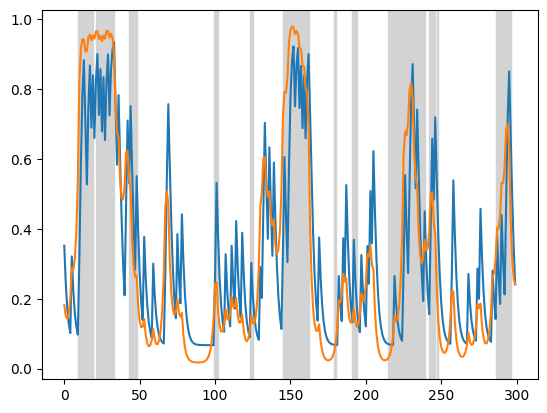

In [12]:
plt.plot(alphas, c='tab:blue')
plt.plot(gammas, c='tab:orange')

changes = list(filter(lambda t: t[1][0] != t[1][1], enumerate(zip(states[:-1], states[1:]))))
for (up, _), (down, _) in zip(changes[:-1:2], changes[1::2]):
    plt.axvspan(up, down, color='lightgray')

## Sanity check

Check results against the `dynamax` library

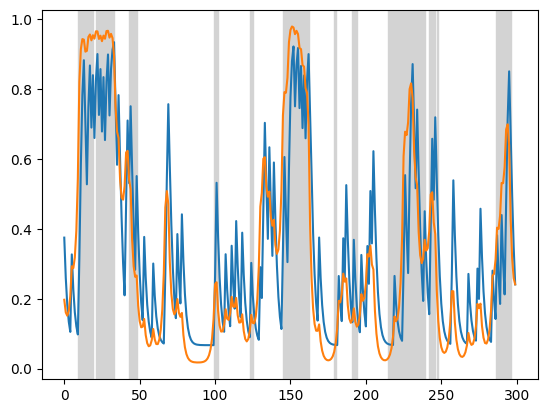

In [13]:
import dynamax
import dynamax.hidden_markov_model

hmm = dynamax.hidden_markov_model.CategoricalHMM(2, 1, 6)
params, _ = hmm.initialize(
    initial_probs=jnp.array([0.5, 0.5]),
    transition_matrix=transition_probabilities[:2],
    emission_probs=emission_probs.reshape(2, 1, 6),
)

emissions = jnp.array(emissions).reshape(T, 1)

posterior = hmm.filter(params, emissions)
alphas = posterior.filtered_probs[:, 1]
posterior = hmm.smoother(params, emissions)
gammas = posterior.smoothed_probs[:, 1]

plt.plot(alphas, c='tab:blue')
plt.plot(gammas, c='tab:orange')
for (up, _), (down, _) in zip(changes[:-1:2], changes[1::2]):
    plt.axvspan(up, down, color='lightgray')